In [1]:
import sys
sys.path.insert(0,'../../../')
from lib.data_processing import GenNLPMaskedDataset
from transformers import ElectraForMaskedLM, ElectraTokenizer, ElectraConfig, TrainingArguments
import pandas as pd
import numpy as np
from lib.utils import general as g
from lib.config.config_class import page_config
from lib.model.overwriter import OTrainingArguments, OTrainer
from lib.utils.metrics import evalpred_to_word, r2_score_transformers
import json
import os
from IPython.display import clear_output
from lib.data_processing import process_ouput as po

# Config

In [2]:
config = None
with g.reading('/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/config.json') as cf:
    config = json.load(cf)
assert config is not None, "config can't none"

In [3]:
regions = [1,2,3,4,5,6,7,8,9,10,11,12]
batchs = [0,1,2,3,4,5,6,7,8]
train_region_paths = page_config.get_file_paths(config[page_config.file_train_prefix],page_config.page,regions,batchs)
test_region_paths = page_config.get_file_paths(config[page_config.file_test_prefix],page_config.page,regions,[0])
vocab_file = config[page_config.vocab_file]
save_dir = config[page_config.save_dir]

In [5]:
training_args = OTrainingArguments(**config[page_config.train_args])
output_dir = training_args.output_dir
logging_dir = training_args.logging_dir
modeling_args = ElectraConfig(**config[page_config.model_args])
tokenizer = ElectraTokenizer(vocab_file=vocab_file)
seed = training_args.seed

## Train

In [ ]:
for i, region in enumerate(regions):
    clear_output(wait=True)
    save_path = save_dir.format(region)
    prevert_path = save_dir.format(region-1)
    ## Train and eval data
    train_batch_paths = train_region_paths[i]
    train_dataset = GenNLPMaskedDataset(
        train_batch_paths[:-1],
        tokenizer,
        seed=seed,
        masked_by_flag=True,
        # masked_per=0.15,
        only_input=True,
        force_create=True)
    eval_dataset = GenNLPMaskedDataset(train_batch_paths[-1:],tokenizer,seed=seed,masked_by_flag=True,only_input=True)
    ## test data
    test_batch_paths = test_region_paths[i]
    test_dataset = GenNLPMaskedDataset(test_batch_paths,tokenizer,seed=seed,masked_by_flag=True,only_input=True)
    ## model
    modeling_args.vocab_size = tokenizer.vocab_size
    modeling_args.max_position_embeddings = 1300
    electra_model = ElectraForMaskedLM(modeling_args)
    if os.path.isdir(prevert_path):
        electra_model = ElectraForMaskedLM.from_pretrained(prevert_path)
    training_args.output_dir = output_dir.format(region)
    training_args.logging_dir = logging_dir.format(region)
    trainer = OTrainer(
        model = electra_model,
        args=training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        compute_metrics = r2_score_transformers,
    )
    trainer.train()
    trainer.save_model(save_path)
    output_test = trainer.predict(test_dataset)
    metrics = output_test.metrics
    test_result_path = os.path.join(save_path,'test_result.json')
    with g.writing(test_result_path) as trf:
        json.dump(metrics,trf)

# Run show r2 plot

In [7]:
true_data = []
pred_data = []
for i, region in enumerate(regions):
    clear_output(wait=True)
    ## Train and eval data
    train_batch_paths = train_region_paths[i]
    train_dataset = GenNLPMaskedDataset()
    eval_dataset = GenNLPMaskedDataset()
    ## test data
    test_batch_paths = test_region_paths[i]
    test_dataset = GenNLPMaskedDataset(test_batch_paths,tokenizer,seed=seed,masked_by_flag=True,only_input=True)
    save_path = save_dir.format(region)
    #Load model
    electra_model = ElectraForMaskedLM.from_pretrained(save_path)
    training_args.output_dir = output_dir.format(region)
    training_args.logging_dir = logging_dir.format(region)
    trainer = OTrainer(
        model = electra_model,
        args=training_args,
        train_dataset = train_dataset,
        eval_dataset = eval_dataset,
        compute_metrics = r2_score_transformers,
    )
    output_test = trainer.predict(test_dataset)
    labels, top_word = evalpred_to_word(output_test)
    true_data.append(labels)
    pred_data.append(top_word)

preprocess data from document:   0%|          | 0/1 [00:00<?, ?it/s]

loading configuration file /client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/data_dir/model/region0012/config.json
Model config ElectraConfig {
  "_name_or_path": "/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/data_dir/model/region0011",
  "architectures": [
    "ElectraForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "embedding_size": 64,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 128,
  "initializer_range": 0.02,
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 1300,
  "model_type": "electra",
  "num_attention_heads": 4,
  "num_hidden_layers": 1,
  "pad_token_id": 0,
  "position_embedding_type": "relative_key",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.8.2",
  "type_vocab_size": 2,
  "vocab_size": 8
}

loading weights file /client/user1/cuongdev/GenImputation/data/

In [8]:
variant_ids = page_config.get_file_paths_in_dir('/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/corpus_dir/',page_config.variant)
variant_ids.sort()

In [9]:
df_origin = None
for i, region in enumerate(regions):
    temp = pd.read_csv(variant_ids[region],sep=page_config.page_split_params)
    if df_origin is None:
        df_origin = temp.copy()
    else:
        df_origin = pd.concat([df_origin,temp])

In [10]:
true_data = [d[:,1:-1] for d in true_data]
pred_data = [d[:,1:-1] for d in pred_data]

In [53]:
y_true = np.concatenate(true_data,axis=1)
y_pred = np.concatenate(pred_data,axis=1)
y_true.shape, y_pred.shape

((200, 12131), (200, 12131))

In [54]:
masked_indexs = df_origin['flag'].values == 0

In [55]:
mafs = np.array(list(map(lambda af: af if af <= 0.5 else 1-af,df_origin['AF'].values)))
mafs = mafs[masked_indexs]
y_true = y_true.T[masked_indexs]
y_pred = y_pred.T[masked_indexs]

In [56]:
cols = ['CHROM','POS','REF','ALT']
paper_format = '/client/user1/cuongdev/GenImputation/temp/chr22_{}.gen'
paper_data = []
for i, region in enumerate(regions):
    paper_path = paper_format.format(region+1)
    temp = pd.read_csv(paper_path,sep=' ',header=None)
    temp.drop(columns=[0],inplace=True)
    temp.rename(columns={1:'CHROM',2:'POS',3:'REF',4:'ALT'},inplace=True)
    temp['CHROM'] = np.full(temp.shape[0],22)
    paper_data.append(temp)
paper_data = pd.concat(paper_data)
paper_data = pd.merge(df_origin[cols],paper_data,how='inner',on=cols)
paper_pred = paper_data[np.arange(5,205)].values

In [58]:
# decode data
for i in range(y_true.shape[0]):
    for j in range(y_true.shape[1]):
        temp = tokenizer.decode(int(y_true[i,j]))
        if temp == '.':
            y_true[i,j] = 0
        else:
            y_true[i,j] = int(temp)
        temp = tokenizer.decode(int(y_pred[i,j]))
        if temp == '.':
            y_pred[i,j] = 0
        else:
            y_pred[i,j] = int(temp)

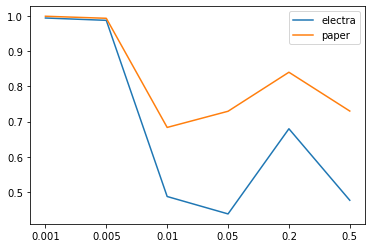

([0.001, 0.005, 0.01, 0.05, 0.2, 0.5],
 {'electra': array([0.995     , 0.98833333, 0.48684007, 0.43728096, 0.67967329,
         0.47611564]),
  'paper': array([1.        , 0.99416667, 0.68347036, 0.72951658, 0.84059458,
         0.73009582])})

In [61]:
po.plot_r2_by_maf(mafs,y_true,{'electra':y_pred,'paper':paper_pred})

In [63]:
result_path_format = '/client/user1/cuongdev/GenImputation/data/train/electra_G1K_22_hs37d5/data_dir/model/region{:04d}/test_result.json'

In [64]:
result_r2 = []
for i, region in enumerate(regions):
    result_path = result_path_format.format(region)
    with g.reading(result_path) as rf:
        result_data = json.load(rf)
        result_r2.append(result_data['test_R2 score VS'])

In [66]:
paper_region_r2 = [0.5061524256812094,
0.7149501541501868,
0.8952640457566468,
0.8363427507857102,
0.8801343570854064,
0.9107906599707585,
0.8952103103470134,
0.7945351710895777,
0.8546739333106563,
0.9344685235893424,
-0.05712632206381623,
0.8971539939313167]

In [67]:
pd.DataFrame({'own':result_r2,'paper':paper_region_r2})

,own,paper
0,0.536483,0.506152
1,0.589706,0.714950
2,0.776381,0.895264
3,0.720946,0.836343
4,0.837222,0.880134
5,0.902317,0.910791
6,0.853948,0.895210
7,0.741350,0.794535
8,0.821319,0.854674
9,0.896605,0.934469
